# Titanic : Machine Learning from Disaster
### Kaggle Competition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
C = sns.color_palette("deep", 8)

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split, KFold
from sklearn.neighbors import KernelDensity

from evolutionary_search import EvolutionaryAlgorithmSearchCV
from tpot import TPOT

import ipyparallel as ipp
from multiprocessing import Pool

from subprocess import call
from glob import glob
import os

/Users/qcaudron/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Datasets

In [2]:
# Import datasets

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

datasets = [train_df, test_df]

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Exploratory analysis

### Name

In [5]:
train_df.Name.head(20)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

- Passenger titles may be useful.
- We can distinguish married and unmarried women ( Mrs versus Miss ).
- We can have a "married couples who are both onboard" binary indicator variable.
- We can fill in blank ages by median age of (Mrs, Miss) and (Mr, Master).

In [6]:
# New feature : title

train_df["Title"] = [name.split(".")[0].split(" ")[-1] for name in train_df.Name]
train_df.Title.replace(["Dr", "Rev", "Don", "Major", "Sir", "Col", "Capt"], "Mr", inplace=True)
train_df.Title.replace(["Mme", "Lady", "Countess"], "Mrs", inplace=True)
train_df.Title.replace(["Mlle", "Ms"], "Miss", inplace=True)
train_df.Title.replace("Jonkheer", "Master", inplace=True)

In [7]:
# New feature : is spouse onboard ?

def spouse_onboard(name) :
    if "Mrs." in name : # if name is female
        lastname = name.split(", Mrs.")[0]
        firstname = name.split("Mrs. ")[1].split(" ")[0]
        for potential_husband in train_df.Name :
            if "{}, Mr. {}".format(lastname, firstname) in potential_husband :
                return 1
        return 0
    elif "Mr." in name : # if name is male
        lastname = name.split(", Mr.")[0]
        firstname = name.split("Mr. ")[1].split(" ")[0]
        for potential_wife in train_df.Name :
            if "{}, Mrs. {}".format(lastname, firstname) in potential_wife :
                return 1
        return 0
    else : # young ( unmarried ) male or female
        return 0

    
train_df["SpouseOnboard"] = train_df.Name \
    .replace(["Dr", "Rev", "Don", "Major", "Sir", "Col", "Capt"], "Mr") \
    .replace(["Mme", "Lady", "Countess"], "Mrs") \
    .apply(spouse_onboard)
    
    
train_df.loc[550].SpouseOnboard = 0 # John Borland Jr. has the same name as his father...

/Users/qcaudron/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [8]:
# New feature : married without husband onboard ?

train_df["MarriedNoHusband"] = (train_df.Title == "Mrs") & (train_df.SpouseOnboard == False)

### Age and Sex

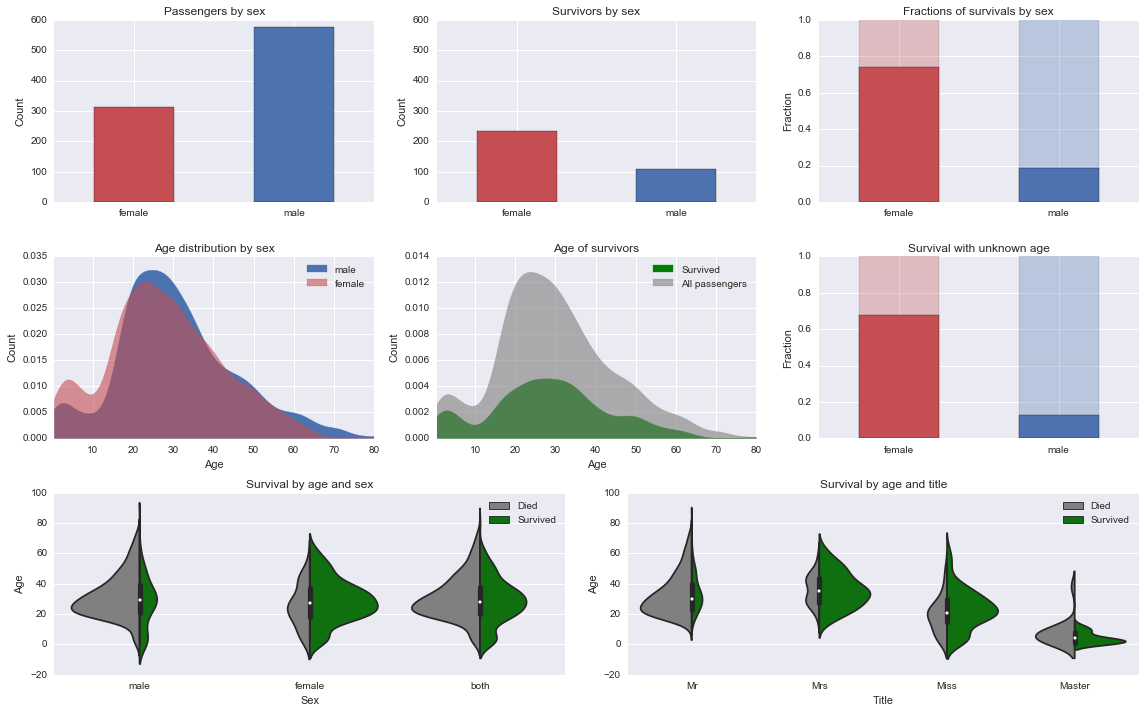

In [9]:
plt.figure(figsize=(16,10))

plt.subplot2grid((3, 6), (0, 0), colspan=2)
plt.title("Passengers by sex")
train_df.groupby(["Sex"]).size().plot(kind="bar", color=[C[2], C[0]], stacked=True)
plt.xticks([0, 1], ["female", "male"], rotation="horizontal")
plt.ylabel("Count")
plt.xlabel("")

plt.subplot2grid((3, 6), (0, 2), colspan=2)
plt.title("Survivors by sex")
train_df.groupby("Sex").Survived.sum().plot(kind="bar", stacked=True, color=[C[2], C[0]])
plt.xticks([0, 1], ["female", "male"], rotation="horizontal")
plt.ylabel("Count")
plt.ylim(0, 600)
plt.xlabel("")

plt.subplot2grid((3, 6), (0, 4), colspan=2)
plt.title("Fractions of survivals by sex")
plt.bar([-0.25, 0.75], [1, 1], color=[C[2], C[0]], width=0.5, alpha=0.3)
train_df.groupby(["Sex"]).Survived.mean().plot(kind="bar", stacked=True, color=[C[2], C[0]])
plt.xticks([0, 1], ["female", "male"], rotation="horizontal")
plt.ylim(0, 1)
plt.ylabel("Fraction")
plt.xlabel("")

plt.subplot2grid((3, 6), (1, 0), colspan=2)
x = np.linspace(train_df.Age.min(), train_df.Age.max(), 200)
yMale = KernelDensity(bandwidth=3).fit(train_df[train_df.Sex == "male"].Age.dropna().values.reshape(-1, 1))
yFemale = KernelDensity(bandwidth=3).fit(train_df[train_df.Sex == "female"].Age.dropna().values.reshape(-1, 1))
plt.fill_between(x, 0, np.exp(yMale.score_samples(x.reshape(-1, 1))), alpha=1, color=C[0])
plt.fill_between(x, 0, np.exp(yFemale.score_samples(x.reshape(-1, 1))), alpha=0.6, color=C[2])
plt.legend(["male", "female"])
plt.xlabel("Age")
plt.title("Age distribution by sex")
plt.ylabel("Count")
plt.xlim(train_df.Age.min(), train_df.Age.max())

plt.subplot2grid((3, 6), (1, 2), colspan=2)
x = np.linspace(train_df.Age.min(), train_df.Age.max(), 200)
ySurvived = KernelDensity(bandwidth=3).fit(train_df[train_df.Survived == 1].Age.dropna().values.reshape(-1, 1))
yTotal = KernelDensity(bandwidth=3).fit(train_df.Age.dropna().values.reshape(-1, 1))
survived = np.exp(ySurvived.score_samples(x.reshape(-1, 1)))
survived /= survived.sum()
survived *= train_df.Survived.mean()
total = np.exp(yTotal.score_samples(x.reshape(-1, 1)))
total /= total.sum()
plt.fill_between(x, 0, survived, alpha=1, color="g")
plt.fill_between(x, 0, total, alpha=0.6, color="gray")
plt.legend(["Survived", "All passengers"])
plt.xlabel("Age")
plt.title("Age of survivors")
plt.ylabel("Count")
plt.xlim(train_df.Age.min(), train_df.Age.max())

plt.subplot2grid((3, 6), (1, 4), colspan=2)
plt.title("Fractions of survivals by sex")
plt.bar([-0.25, 0.75], [1, 1], color=[C[2], C[0]], width=0.5, alpha=0.3)
train_df["AgeUnknown"] = train_df.Age.isnull()
train_df[train_df.AgeUnknown].groupby(["Sex"]).Survived.mean().plot(kind="bar", stacked=True, color=[C[2], C[0]])
plt.xticks([0, 1], ["female", "male"], rotation="horizontal")
plt.ylim(0, 1)
plt.ylabel("Fraction")
plt.xlabel("")
plt.title("Survival with unknown age")

plt.subplot2grid((3, 6), (2, 0), colspan=3)
temp_df = train_df[["Age", "Sex", "Survived"]]
temp_df2 = temp_df.copy()
temp_df2.Sex = "all"
temp_df = temp_df.append(temp_df2)
sns.violinplot(data=temp_df, x="Sex", y="Age", hue="Survived", palette={0 : "gray", 1 : "g"}, split=True, scale="count")
plt.title("Survival by age and sex")
plt.xticks([0, 1, 2], ["male", "female", "both"])
handles, _ = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles, ["Died", "Survived"])

plt.subplot2grid((3, 6), (2, 3), colspan=3)
plt.title("Survival by age and title")
sns.violinplot(data=train_df, x="Title", y="Age", hue="Survived", palette={0 : "gray", 1 : "g"}, split=True, scale="count")
handles, _ = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles, ["Died", "Survived"])

plt.tight_layout()

- Sex is a great indicator of survival : ~75% of women survived, only ~20% of men survived. This will be an important feature.
- Age by itself could be a good feature. Young children tend to survive. We might also want to compound age with sex, or extract age categories to help the algorithms a little. 
- Unknown age reduces chance of survival, perhaps a penalty variable is warranted.
- Young males ( Master ) tend to survive compared with males of any age

In [ ]:
# Fill in missing age data, using regression on class
pd.ols(x=train_df[["Pclass", "Fare", ""]], y=train_df.Age)

################ some sort of regression that takes categorical variables

In [ ]:
# New feature : age classes
train_df["AgeClass"] = 0 # 0 to 5 years, "babies"
train_df.loc[(train_df.Age >= 6) & (train_df.Age < 12), "AgeClass"] = 1 # 6 to 11, "children"
train_df.loc[(train_df.Age >= 12) & (train_df.Age < 17), "AgeClass"] = 2 # 12 to 16, "teenagers"
train_df.loc[(train_df.Age >= 17) & (train_df.Age < 56), "AgeClass"] = 3 # 17 to 55, "adults"
train_df.loc[train_df.Age >= 56, "AgeClass"] = 4 # over 56, "elderly"

In [ ]:
train_df[["AgeClass", "Age"]]

### Passenger Class

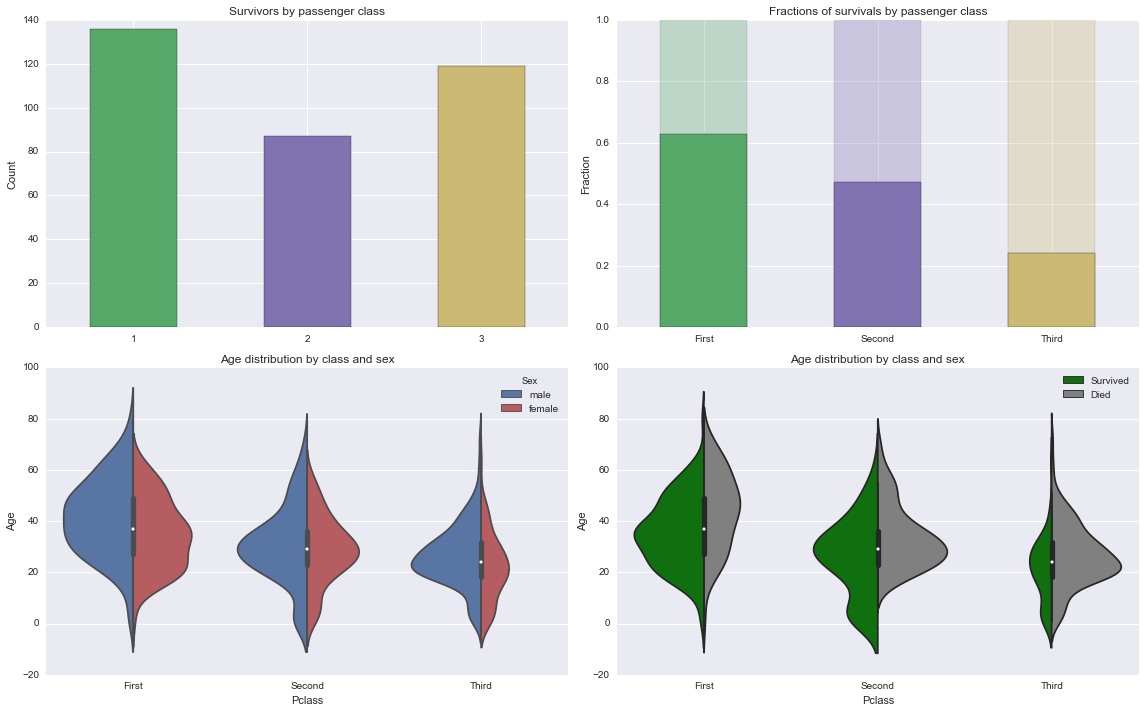

In [13]:
plt.figure(figsize=(16,10))

plt.subplot(221)
plt.title("Survivors by passenger class")
train_df.groupby(["Pclass"]).Survived.sum().plot(kind="bar", stacked=True, color=[C[1], C[3], C[4]])
plt.xticks(range(3), range(1, 4), rotation="horizontal")
plt.ylabel("Count")
plt.xlabel("")

plt.subplot(222)
plt.title("Fractions of survivals by passenger class")
plt.bar([-0.25, 0.75, 1.75], [1, 1, 1], color=[C[1], C[3], C[4]], width=0.5, alpha=0.3)
train_df.groupby(["Pclass"]).Survived.mean().plot(kind="bar", stacked=True, color=[C[1], C[3], C[4]])
plt.xticks([0, 1, 2], ["First", "Second", "Third"], rotation="horizontal")
plt.ylim(0, 1)
plt.ylabel("Fraction")
plt.xlabel("")

plt.subplot(223)
sns.violinplot(data=train_df.sort_values("Pclass"), x="Pclass", y="Age", hue="Sex", split=True, palette={"female" : C[2], "male" : C[0]}, scale="count")
plt.title("Age distribution by class and sex")
plt.xticks([0, 1, 2], ["First", "Second", "Third"])

plt.subplot(224)
sns.violinplot(data=train_df.sort_values("Pclass"), x="Pclass", y="Age", hue="Survived", split=True, palette={0 : "gray", 1 : "g"}, scale="count")
plt.title("Age distribution by class and sex")
plt.xticks([0, 1, 2], ["First", "Second", "Third"])
handles, _ = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles, ["Survived", "Died"])

plt.tight_layout()

- Passenger class is a good predictor of survival : >60% first class, ~45% second class, ~25% third class survival.
- Men and women in first class tended to be older than in other classes - especially men.
- Survivors from the first class males tended to be younger.
- Nearly all first-class and second-class children survived; not so for third class.

### Fares

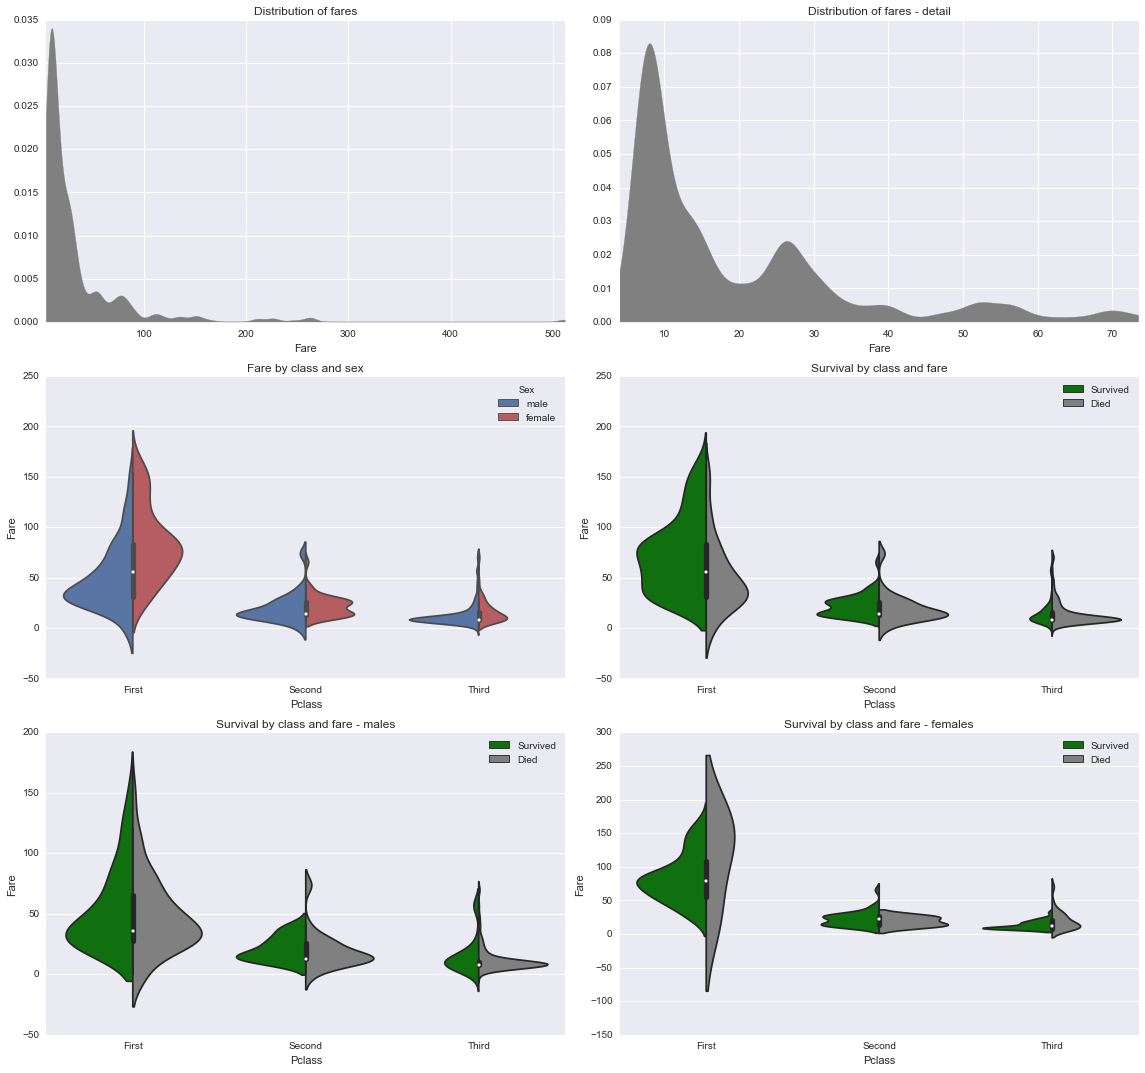

In [14]:
plt.figure(figsize=(16,15))

plt.subplot(321)
plt.title("Distribution of fares")
plt.xlabel("Fare")
x = np.linspace(train_df[train_df.Fare > 0].Fare.min(), train_df[train_df.Fare > 0].Fare.max(), 2000)
kde = KernelDensity(6).fit(train_df[train_df.Fare > 0].Fare.reshape(-1, 1))
y = np.exp(kde.score_samples(x.reshape(-1, 1)))
plt.fill_between(x, 0, y, color="gray")
plt.xlim(train_df[train_df.Fare > 0].Fare.min(), train_df[train_df.Fare > 0].Fare.max())

plt.subplot(322)
plt.title("Distribution of fares - detail")
plt.xlabel("Fare")
condition = (train_df.Fare > 0) & (train_df.Fare < 75)
x = np.linspace(train_df[condition].Fare.min(), train_df[condition].Fare.max(), 2000)
kde = KernelDensity(2).fit(train_df[condition].Fare.reshape(-1, 1))
y = np.exp(kde.score_samples(x.reshape(-1, 1)))
plt.fill_between(x, 0, y, color="gray")
plt.xlim(train_df[condition].Fare.min(), train_df[condition].Fare.max())

plt.subplot(323)
plt.title("Fare by class and sex")
sns.violinplot(data=train_df[train_df.Fare < 200].sort_values("Pclass"), x="Pclass", y="Fare", hue="Sex", split=True, scale="count", palette={"female" : C[2], "male" : C[0]})
plt.xticks([0, 1, 2], ["First", "Second", "Third"])
#handles, _ = plt.gca().get_legend_handles_labels()
#plt.gca().legend(handles, ["Survived", "Died"])

plt.subplot(324)
plt.title("Survival by class and fare")
sns.violinplot(data=train_df[train_df.Fare < 200].sort_values("Pclass"), x="Pclass", y="Fare", hue="Survived", split=True, scale="count", palette={0 : "gray", 1 : "g"})
plt.xticks([0, 1, 2], ["First", "Second", "Third"])
handles, _ = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles, ["Survived", "Died"])

plt.subplot(325)
plt.title("Survival by class and fare - males")
condition = (train_df.Sex == "male") & (train_df.Fare < 200)
sns.violinplot(data=train_df[condition].sort_values("Pclass"), x="Pclass", y="Fare", hue="Survived", split=True, palette={0 : "grey", 1 : "g"})
plt.xticks([0, 1, 2], ["First", "Second", "Third"])
handles, _ = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles, ["Survived", "Died"])

plt.subplot(326)
plt.title("Survival by class and fare - females")
condition = (train_df.Sex == "female") & (train_df.Fare < 200)
sns.violinplot(data=train_df[condition].sort_values("Pclass"), x="Pclass", y="Fare", hue="Survived", split=True, palette={0 : "grey", 1 : "g"})
plt.xticks([0, 1, 2], ["First", "Second", "Third"])
handles, _ = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles, ["Survived", "Died"])

plt.tight_layout()

- Of first-class survivors, those who paid more were more likely to survive; this is not true of second and third class passengers.
- Significant overlap between fares in the second and third classes; perhaps class will therefore be a better indicator of survival.
- Females paid more for first class than males; first class females that paid more had a lower probability of survival - perhaps this "upper first class" is for the older, more wealthy women, and age may confound survival here.
- There are three particularly high fare value of ~512 for one woman and two men, after which the next highest fare is 263. Errors or plausible ? Rescaling or log-transforming might be important here.

### Family

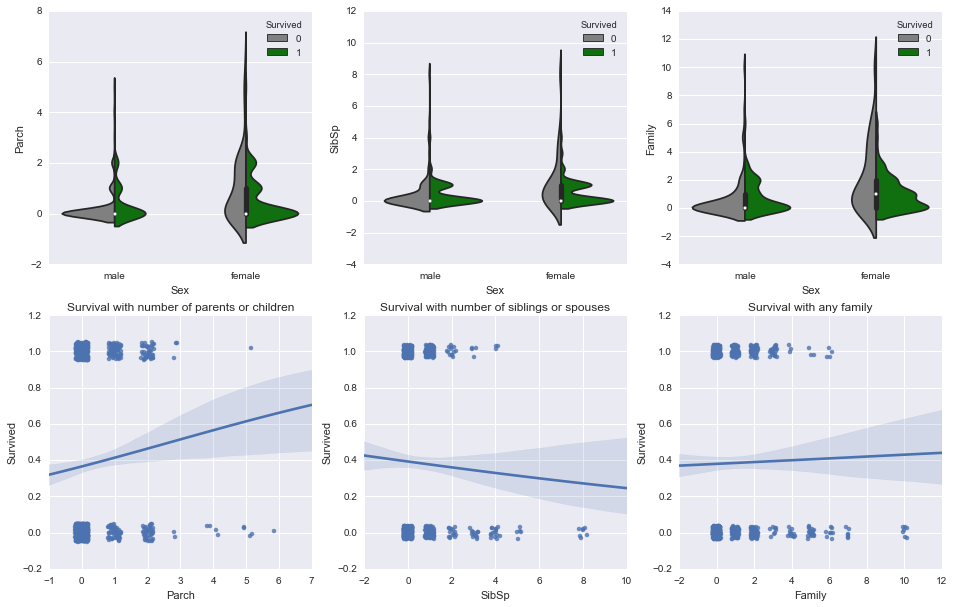

In [15]:
train_df["Family"] = train_df.SibSp + train_df.Parch

plt.figure(figsize=(16,10))

plt.subplot(231)
sns.violinplot(data=train_df, x="Sex", y="Parch", hue="Survived", split=True, palette={0 : "grey", 1 : "g"})

plt.subplot(232)
sns.violinplot(data=train_df, x="Sex", y="SibSp", hue="Survived", split=True, palette={0 : "grey", 1 : "g"})

plt.subplot(233)
sns.violinplot(data=train_df, x="Sex", y="Family", hue="Survived", split=True, palette={0 : "grey", 1 : "g"})

plt.subplot(234)
plt.title("Survival with number of parents or children")
sns.regplot(data=train_df, x="Parch", y="Survived", logistic=True, x_jitter=0.2, y_jitter=0.05)

plt.subplot(235)
plt.title("Survival with number of siblings or spouses")
sns.regplot(data=train_df, x="SibSp", y="Survived", logistic=True, x_jitter=0.2, y_jitter=0.035)

plt.subplot(236)
plt.title("Survival with any family")
sns.regplot(data=train_df, x="Family", y="Survived", logistic=True, x_jitter=0.2, y_jitter=0.035)

In [ ]:
train_df.Fare.max()

In [ ]:
train_df.Fare

In [ ]:
len(train_df[train_df.Fare < 70000])

In [ ]:
len(train_df[train_df.Fare > 200])